In [216]:
import sys
sys.version_info
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import time

In [230]:
pd.set_option('display.max_columns', None)

## First: load in our data and do some basic analysis to look for problems

In [218]:
#read in the data
marathon_data = pd.read_csv("data.csv")
marathon_data = marathon_data.dropna()
marathon_data['Time'] = pd.to_timedelta(marathon_data['Time'])
marathon_data.head()

,Id,Name,Age Category,Sex,Rank,Time,Pace,Year
0,1,carlos enrique portugal quintero,30,M,1263,04:15:00,09:44,2016
1,2,leonel furlan,60,M,2289,05:05:42,11:41,2016
2,3,meredith gray,30,F,2276,05:04:34,11:38,2016
3,4,jason ainspan,35,M,670,03:52:57,08:53,2015
4,4,jason ainspan,35,M,2390,05:13:30,11:58,2016


In [219]:
for yr in marathon_data.groupby('Year').groups: 
    print(yr, str(marathon_data.groupby('Year').get_group(yr)['Time'].mean()))
#here, we are trying to figure out which year was the half marathon (2013)
#Let's drop that year
marathon_data = marathon_data[marathon_data.Year != 2013]
#marathon_data.Year.value_counts()

2016 0 days 04:32:55.103116
2003 0 days 04:18:00.990378
2004 0 days 04:28:34.934463
2005 0 days 04:25:55.415105
2006 0 days 04:37:25.943564
2007 0 days 04:43:34.228222
2008 0 days 04:28:04.394986
2009 0 days 04:29:01.636166
2010 0 days 04:36:43.382291
2011 0 days 04:27:12.712468
2012 0 days 04:35:52.052658
2013 0 days 01:51:27.648069
2014 0 days 04:43:50.870375
2015 0 days 04:30:48.480377


In [220]:
##Do we want to remove the entries without valid name?

#marathon_data.Name.value_counts().sort_values().tail()
#Note: we see that some of the participants have the name set to private. we should probably drop these 
#marathon_data = marathon_data[marathon_data.Name != "private"]
#marathon_data.Name.value_counts().sort_values().tail()
#marathon_data = marathon_data[marathon_data.Name.str.contains("#") == False]
#get rid of one garbage name

In [221]:
marathon_data.sort_values('Time').head()
#This looks good (all the very low times are winners of the race, or close to it)

,Id,Name,Age Category,Sex,Rank,Time,Pace,Year
5268,3243,david ruto,23,M,1,02:12:22,05:03,2003
7631,4390,otavio dos santos p,29,M,2,02:12:23,05:03,2003
6621,3816,kiplimo rono,32,M,3,02:12:40,05:03,2003
24807,17531,tesfaye alemayehu,25,M,1,02:12:57,05:04,2011
8341,4853,william gomez amori,25,M,1,02:14:42,05:08,2004


In [232]:
marathon_data.groupby('Name').size().sort_values().tail(15)
#This is reasonable, we se that some people participated in the marathon each year that it occured

Name
matt duncan         12
mike culp           12
juan carson         12
joseph scott        12
kenneth royster     12
dennis marsella     12
wayne wright        12
mark platt          12
tammy lopez         13
tony jones          13
alan bloom          13
norberto milan      13
paul schoenlaub     13
alexis garcia       13
private            301
dtype: int64

## Now, we have clean data but need to extract the features for our models

In [301]:
data_pivot = pd.pivot_table(marathon_data, index = ["Id"], columns = "Year", values = ["Rank","Age Category", "Time"], aggfunc= "first")


def create_frame(last_year):
    start = time.time()
    
    #This is the function to create a frame with the relavant features for each runner, given a year
    #The basic process is we create a pandas pivot table to help us, then we iterate over this pivot table (mostly using apply)
    #to create a new pandas dataframe (new_frame) that contains all relavent features 
    
    #the year we input (last_year) is the last year that we look at (1 year back from current)
    #IE, if we are looking to predict for 2017, we would give 2016 as the last_year, and the features would include all years up to 2016
    
    new_frame = pd.DataFrame(data = {"Id": marathon_data.Id, "Sex": marathon_data.Sex})
    new_frame = working_frame.drop_duplicates("Id")
    new_frame["Sex"] = pd.get_dummies(working_frame["Sex"])
    #1 is male, 0 is female
    
    new_frame.index = new_frame.Id
    
    #helper functions
    def lastfilled(row):
        key = last_year
        while pd.isnull(row.loc[key]): 
            key = key-1
            if (key == 2013):
                key = key - 1
            if (key < 2003): 
                return None 
        return (last_year - key + 1)
        
    def valuelast(row):
        key = last_year
        while pd.isnull(row.loc[key]): 
            key = key - 1
            if (key == 2013):
                key = key - 1
            if (key < 2003): 
                return None
        return row.loc[key]
    
    
    for i in range(0,(last_year - 2003)):
        #Here we iterate over the relavent columns in order to get the dummies for participation
        #Each column will be a boolean variable, with a 0 if the runner participated that year, and a 0 otherwise
        #the output is expressed in terms of lags: IE, Lag_1 is one year ago, Lag_4 is 4 years ago...
        new_frame["_".join(("Lag",str(i + 1)))] = pd.isnull(data_pivot["Rank"]).iloc[:,(last_year - 2004 - i)].apply(lambda x: 0 if x else 1)

    new_frame["Num Marathons"] = data_pivot.apply(lambda x: x.iloc[0:(last_year - 2003)].count() , axis = 1)
    #number of marathons ran
    new_frame["Years Since Last"] = data_pivot.apply(lambda x: lastfilled(x["Rank"]), axis = 1)
    #years since last ra 
    new_frame["Time of Last"] = data_pivot.apply(lambda x: valuelast(x["Time"]), axis = 1)
    #time of the last marathon they competed in 
    new_frame["Age Last"] = data_pivot.apply(lambda x: valuelast(x["Age Category"]), axis = 1)
    #NOTE: these apply functions are very time-costly. It takes around 60seconds to run this function fully
    #It would be possible to optimize this, but I am not sure if it is worth my time
    
    #Normalization on the time column 
    new_frame["Time of Last"] = (new_frame["Time of Last"] - new_frame["Time of Last"].min()) / (new_frame["Time of Last"].max() - new_frame["Time of Last"].min())
    
    del new_frame["Id"]
    
    print(time.time() - start)
    return new_frame

In [247]:
my_frame = create_frame(2015)

59.192607164382935


In [253]:
my_frame.head()

,Id,Sex,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6,Lag_7,Lag_8,Lag_9,Lag_10,Lag_11,Lag_12,Num Marathons,Years Since Last,Time of Last,Age Last
Id,,,,,,,,,,,,,,,,,,
1,1,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaT,NaN
2,2,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaT,NaN
3,3,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaT,NaN
4,4,1.0,1,0,0,0,0,0,0,0,0,0,0,0,1,1.0,03:52:57,35.0
5,5,0.0,0,1,1,1,1,1,1,1,1,0,0,0,8,2.0,05:43:14,42.0


In [235]:
my_frame["Time_Sex"] = my_frame["Sex"] * my_frame["Time of Last"]
my_frame.head()

,Id,Sex,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6,Lag_7,Lag_8,Lag_9,Lag_10,Lag_11,Lag_12,Lag_13,Num Marathons,Years Since Last,Time of Last,Age Last,Time_Sex
Id,,,,,,,,,,,,,,,,,,,,
1,1,1.0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,04:15:00,30,04:15:00
2,2,1.0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,05:05:42,60,05:05:42
3,3,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,05:04:34,30,00:00:00
4,4,1.0,1,1,0,0,0,0,0,0,0,0,0,0,0,2,1,05:13:30,35,05:13:30
5,5,0.0,1,0,1,1,1,1,1,1,1,1,0,0,0,9,1,05:28:34,40,00:00:00


In [254]:
#Verify this data against the data in the pivot table
data_pivot.head()

Rank                                                                    \
Year  2003  2004  2005  2006  2007  2008  2009  2010  2011  2012  2014  2015   
Id                                                                             
1     None  None  None  None  None  None  None  None  None  None  None  None   
2     None  None  None  None  None  None  None  None  None  None  None  None   
3     None  None  None  None  None  None  None  None  None  None  None  None   
4     None  None  None  None  None  None  None  None  None  None  None   670   
5     None  None  None  2013  2002  2343  2415  2455  3140  3329  3086  None   

           Age Category                                                        \
Year  2016         2003  2004  2005  2006  2007  2008  2009  2010  2011  2012   
Id                                                                              
1     1263         None  None  None  None  None  None  None  None  None  None   
2     2289         None  None  None  None  None  None  None  None  None  None   
3     2276         None  None  None  None  None  None  None  None  None  None   
4     2390         None  None  None  None  None  None  None  None  None  None   
5     2608         None  None  None    34    35    36    37    38    39    40   

                       Time                                                \
Year  2014  2015 2016  2003  2004  2005             2006             2007   
Id                                                                          
1     None  None   30  None  None  None             None             None   
2     None  None   60  None  None  None             None             None   
3     None  None   30  None  None  None             None             None   
4     None    35   35  None  None  None             None             None   
5       42  None   40  None  None  None  0 days 05:29:32  0 days 05:26:12   

                                                                          \
Year             2008             2009             2010             2011   
Id                                                                         
1                None             None             None             None   
2                None             None             None             None   
3                None             None             None             None   
4                None             None             None             None   
5     0 days 05:28:49  0 days 05:27:27  0 days 05:29:04  0 days 05:28:24   

                                                                          
Year             2012             2014             2015             2016  
Id                                                                        
1                None             None             None  0 days 04:15:00  
2                None             None             None  0 days 05:05:42  
3                None             None             None  0 days 05:04:34  
4                None             None  0 days 03:52:57  0 days 05:13:30  
5     0 days 05:28:35  0 days 05:43:14             None  0 days 05:28:34

In [228]:
my_frame.as_matrix()
#As you can see, we can represent this data as a matrix as well:

array([[1, 1.0, 1, ..., 1, Timedelta('0 days 04:15:00'), 30],
       [2, 1.0, 1, ..., 1, Timedelta('0 days 05:05:42'), 60],
       [3, 0.0, 1, ..., 1, Timedelta('0 days 05:04:34'), 30],
       ..., 
       [30415, 0.0, 0, ..., 2, Timedelta('0 days 03:44:54'), 45],
       [30416, 1.0, 0, ..., 2, Timedelta('0 days 03:51:36'), 35],
       [30417, 1.0, 0, ..., 2, Timedelta('0 days 02:50:26'), 40]], dtype=object)

## Now: Logistic Regression 

As logistic regression is a supervised learning model, we need to train the model using a y-vector of instances of correct categorization that we have. This is acomplished by using 2016 as our  categorization year, and using as our features set the data on participation in races from 2003 to 2015. In this case, we exclude all participants who do not have a race between 2003 and 2015 (those who only race in 2016). 

In [290]:
#Create our dataframe, looking back from 2016
train_df = create_frame(2015)

64.9304358959198


In [344]:
#The other component that we need is our y-vector, which is the participation boolean for 2016
y_vect = pd.isnull(data_pivot["Rank"]).iloc[:,(12)].apply(lambda x: 0 if x else 1)
y_vect = y_vect.loc[train_df.index]
y_vect = y_vect.as_matrix()
y_vect

array([1, 1, 1, ..., 0, 0, 0])

In [291]:
#remove entries where there are no races
train_df = train_df[train_df["Num Marathons"] > 0 ]
train_df.head()
#We lost about 2,000 entries, but still have a large number: > 25,000

,Id,Sex,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6,Lag_7,Lag_8,Lag_9,Lag_10,Lag_11,Lag_12,Num Marathons,Years Since Last,Time of Last,Age Last
Id,,,,,,,,,,,,,,,,,,
4,4,1.0,1,0,0,0,0,0,0,0,0,0,0,0,1,1.0,0.270143,35.0
5,5,0.0,0,1,1,1,1,1,1,1,1,0,0,0,8,2.0,0.566338,42.0
7,7,1.0,0,1,0,0,0,0,0,0,0,0,0,0,1,2.0,0.301746,42.0
9,9,1.0,1,1,1,0,0,0,0,0,0,0,0,0,3,1.0,0.343062,50.0
11,11,0.0,1,1,0,0,0,0,0,0,0,0,0,0,2,1.0,0.525112,40.0


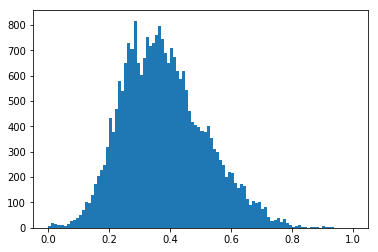

In [302]:
plt.hist(train_df["Time of Last"], bins = 100)
plt.show()

In [304]:
train_array = train_df.as_matrix()

In [469]:
#We now have 17 features, so we can initialize our weights vector to the zero vector 
w_vector = np.zeros(17)
w_vector

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.])

In [514]:
error_fxn(w_vect)

17465.922655749531

In [518]:
error_fxn(np.array([-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1]))

36294.597537632086

In [490]:
grad_fxn(w_vect)

array([  -7406.      ,    -923.      ,   -1398.5     ,   -1705.5     ,
         -1591.      ,   -1294.5     ,   -1272.5     ,   -1219.      ,
         -1182.      ,   -1162.      ,    -825.      ,    -842.      ,
          -696.5     ,  -14111.5     ,  -75985.5     ,   -4523.135094,
       -448812.5     ])

In [502]:
np.log(1 - sigmoid(np.dot(train_array, w_vect))).dot((1-y_vect))

-16952.993742135171

In [519]:
def sigmoid(x):
    return 1 / (1 + np.exp(-1 * x))

def error_fxn(w_vect):
    #This function computes the error function, given a weights vector w_vect
    #This allow us to call this function repeatedly as we optimize the w_vect through gradient descent
    y0 = np.log(sigmoid(train_array.dot(w_vect))).dot(y_vect)
    y1 = np.log(1 - sigmoid(train_array.dot(w_vect))).dot(1-y_vect)
    
    return -(y0 + y1)

def grad_fxn(w_vect): 
    #This function computes the gradient function, given the weights vector w_vect
    return np.dot((y_vect - sigmoid(np.dot(train_array, w_vect))),train_array)

def grad_descent(w_vect, step, tol):
    #performs the gradient descent
    delta = error_fxn(w_vect)
    i = 0
    
    while(delta > tol): 
        w_old = w_vect
        w_vect = w_old - step * grad_fxn(w_old)
        delt = error_fxn(w_vect) - error_fxn(w_old)
        i = i + 1
        if(i > 1000):
            break
    print(i)
    return w_vect

In [509]:
my_w = grad_descent(np.zeros(17), .01, 0.001)
error_fxn(my_w)

1001


nan

In [510]:
my_w

array([  9.49176604e+01,   8.77718328e+02,   9.26321768e+01,
         3.77340268e+02,   1.28396198e+02,   1.25729515e+02,
         4.15650536e+01,   1.16072148e+02,   5.37146718e+01,
         4.63750309e+01,   3.98382350e+01,  -4.37131654e+01,
        -6.78895724e-02,   1.85560057e+03,  -8.52606839e+02,
        -2.09938762e+02,  -1.22175579e+03])

In [511]:
grad_fxn(w_vect)

array([  -7406.      ,    -923.      ,   -1398.5     ,   -1705.5     ,
         -1591.      ,   -1294.5     ,   -1272.5     ,   -1219.      ,
         -1182.      ,   -1162.      ,    -825.      ,    -842.      ,
          -696.5     ,  -14111.5     ,  -75985.5     ,   -4523.135094,
       -448812.5     ])

In [512]:
error_fxn(w_vect)

17465.922655749531

In [455]:
sigmoid(w_vect)

array([ 0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,
        0.5,  0.5,  0.5,  0.5,  0.5,  0.5])

In [424]:
np.dot((y_vect - sigmoid(np.zeros(len(y_vect)))), train_array)

array([  -7406.      ,    -923.      ,   -1398.5     ,   -1705.5     ,
         -1591.      ,   -1294.5     ,   -1272.5     ,   -1219.      ,
         -1182.      ,   -1162.      ,    -825.      ,    -842.      ,
          -696.5     ,  -14111.5     ,  -75985.5     ,   -4523.135094,
       -448812.5     ])

In [456]:
error_fxn(my_w)

0.67279124304052484